# ARCH Modeling

_This setup code is required to run in an IPython notebook_

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('darkgrid')
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font",family="sans-serif")
plt.rc("font",size=14)

## Setup

These examples will all make use of financial data from Yahoo! Finance.  This data set can be loaded from `arch.data.sp500`.

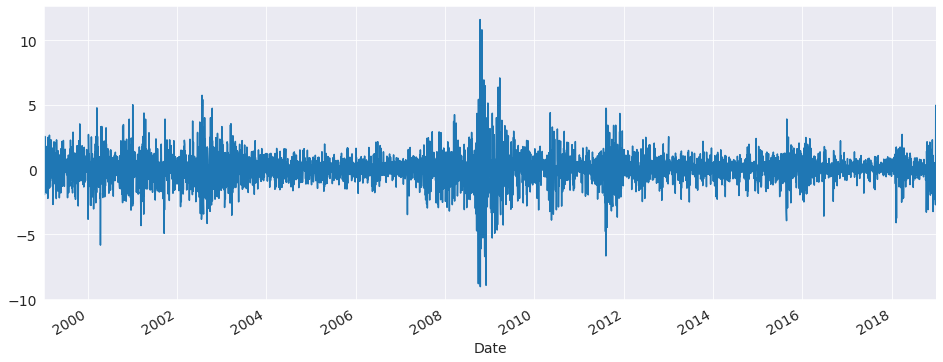

In [2]:
import datetime as dt

import arch.data.sp500

st = dt.datetime(1988, 1, 1)
en = dt.datetime(2018, 1, 1)
data = arch.data.sp500.load()
market = data['Adj Close']
returns = 100 * market.pct_change().dropna()
ax = returns.plot()
xlim = ax.set_xlim(returns.index.min(), returns.index.max())

## Specifying Common Models

The simplest way to specify a model is to use the model constructor `arch.arch_model` which can specify most common models.  The simplest invocation of `arch` will return a model with a constant mean, GARCH(1,1) volatility process and normally distributed errors.


$$ r_t  =  \mu + \epsilon_t$$

$$\sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2 $$

$$\epsilon_t  =  \sigma_t e_t,\,\,\, e_t  \sim  N(0,1) $$


The model is estimated by calling `fit`.  The optional inputs `iter` controls the frequency of output form the optimizer, and `disp` controls whether convergence information is returned.  The results class returned offers direct access to the estimated parameters and related quantities, as well as a `summary` of the estimation results.

### GARCH (with a Constant Mean)

The default set of options produces a model with a constant mean, GARCH(1,1) conditional variance and normal errors.

In [3]:
from arch import arch_model

am = arch_model(returns)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6942.159596737265
Iteration:     10,   Func. Count:     72,   Neg. LLF: 6936.718529994181
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6936.718476989043
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Mon, Mar 02 2020   Df Residuals:                     5026
Time:         

`plot()` can be used to quickly visualize the standardized residuals and conditional volatility.  

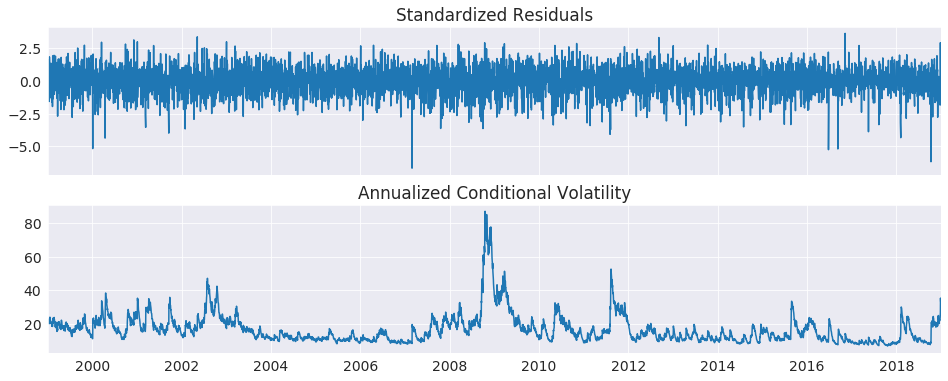

In [4]:
fig = res.plot(annualize='D')

### GJR-GARCH

Additional inputs can be used to construct other models.  This example sets `o` to 1, which includes one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics given by 

$$
\sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \gamma \epsilon_{t-1}^2 I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1}^2 
$$

where $I$ is an indicator function that takes the value 1 when its argument is true.

The log likelihood improves substantially with the introduction of an asymmetric term, and the parameter estimate is highly significant.

In [5]:
am = arch_model(returns, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -6822.88
Distribution:                  Normal   AIC:                           13655.8
Method:            Maximum Likelihood   BIC:                           13688.4
                                        No. Observations:                 5030
Date:                Mon, Mar 02 2020   Df Residuals:                     5025
Time:                        11:53:28   Df Model:                            5
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0175  1.145e-02      1.529      0.126 

### TARCH/ZARCH

TARCH (also known as ZARCH) model the _volatility_ using absolute values.  This model is specified using `power=1.0` since the default power, 2, corresponds to variance processes that evolve in squares.

The volatility process in a TARCH model is given by 

$$
\sigma_t  =  \omega + \alpha \left|\epsilon_{t-1}\right| + \gamma \left|\epsilon_{t-1}\right| I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1} 
$$

More general models with other powers ($\kappa$) have volatility dynamics given by 

$$
\sigma_t^\kappa   = \omega + \alpha \left|\epsilon_{t-1}\right|^\kappa + \gamma \left|\epsilon_{t-1}\right|^\kappa I_{[\epsilon_{t-1}<0]}+ \beta \sigma_{t-1}^\kappa 
$$

where the conditional variance is $\left(\sigma_t^\kappa\right)^{2/\kappa}$.

The TARCH model also improves the fit, although the change in the log likelihood is less dramatic.

In [6]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     49,   Neg. LLF: 6807.734808859357
Iteration:     10,   Func. Count:     88,   Neg. LLF: 6799.179902576483
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6799.17852245191
            Iterations: 14
            Function evaluations: 116
            Gradient evaluations: 13
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -6799.18
Distribution:                  Normal   AIC:                           13608.4
Method:            Maximum Likelihood   BIC:                           13641.0
                                        No. Observations:                 5030
Date:                Mon, Mar 02 2020   Df Residuals:                     5025
Time:         

### Student's T Errors

Financial returns are often heavy tailed, and a Student's T distribution is a simple method to capture this feature.  The call to `arch` changes the distribution from a Normal to a Students's T.

The standardized residuals appear to be heavy tailed with an estimated degree of freedom near 10.  The log-likelihood also shows a large increase.

In [7]:
am = arch_model(returns, p=1, o=1, q=1, power=1.0, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     54,   Neg. LLF: 6726.104807616888
Iteration:     10,   Func. Count:     99,   Neg. LLF: 6722.153431139288
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6722.151184378068
            Iterations: 13
            Function evaluations: 121
            Gradient evaluations: 12
                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                    Adj Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -6722.15
Distribution:      Standardized Student's t   AIC:                           13456.3
Method:                  Maximum Likelihood   BIC:                           13495.4
                                              No. Observations:                 5030
Date:                      Mon, Mar 02 2020   Df R

## Fixing Parameters
In some circumstances, fixed rather than estimated parameters might be of interest.  A model-result-like class can be generated using the `fix()` method.  The class returned is identical to the usual model result class except that information about inference (standard errors, t-stats, etc) is not available. 

In the example, I fix the parameters to a symmetric version of the previously estimated model.

In [8]:
fixed_res = am.fix([0.0235, 0.01, 0.06, 0.0, 0.9382, 8.0])
print(fixed_res.summary())

                      Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                     Adj Close   R-squared:                          --
Mean Model:                    Constant Mean   Adj. R-squared:                     --
Vol Model:                       TARCH/ZARCH   Log-Likelihood:               -6908.93
Distribution:       Standardized Student's t   AIC:                           13829.9
Method:            User-specified Parameters   BIC:                           13869.0
                                               No. Observations:                 5030
Date:                       Mon, Mar 02 2020                                         
Time:                               11:53:28                                         
      Mean Model     
                 coef
---------------------
mu             0.0235
   Volatility Model  
                 coef
---------------------
omega          0.0100
alpha[1]       0.0600
gamma[1]       0.0000
beta[1

(729759.0, 737059.0)

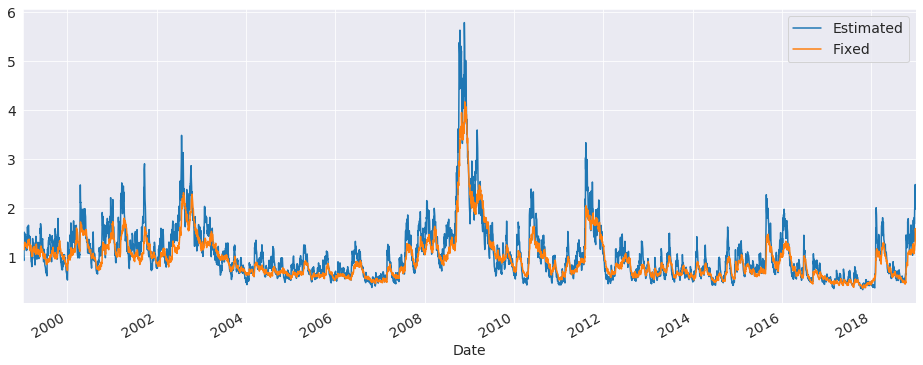

In [9]:
import pandas as pd
df = pd.concat([res.conditional_volatility, fixed_res.conditional_volatility],
               1)
df.columns = ['Estimated', 'Fixed']
subplot = df.plot()
subplot.set_xlim(xlim)

## Building a Model From Components

Models can also be systematically assembled from the three model components:

* A mean model (`arch.mean`)
    * Zero mean (`ZeroMean`) - useful if using residuals from a model estimated separately
    * Constant mean (`ConstantMean`) - common for most liquid financial assets
    * Autoregressive (`ARX`) with optional exogenous regressors
    * Heterogeneous (`HARX`) autoregression with optional exogenous regressors
    * Exogenous regressors only (`LS`)
* A volatility process (`arch.volatility`)
    * ARCH (`ARCH`)
    * GARCH (`GARCH`)
    * GJR-GARCH (`GARCH` using `o` argument) 
    * TARCH/ZARCH (`GARCH` using `power` argument set to `1`)
    * Power GARCH and Asymmetric Power GARCH (`GARCH` using `power`)
    * Exponentially Weighted Moving Average Variance with estimated coefficient (`EWMAVariance`)
    * Heterogeneous ARCH (`HARCH`)
    * Parameterless Models
        * Exponentially Weighted Moving Average Variance, known as RiskMetrics (`EWMAVariance`)
        * Weighted averages of EWMAs, known as the RiskMetrics 2006 methodology (`RiskMetrics2006`)
* A distribution (`arch.distribution`)
    * Normal (`Normal`)
    * Standardized Students's T (`StudentsT`)

### Mean Models

The first choice is the mean model.  For many liquid financial assets, a constant mean (or even zero) is adequate.  For other series, such as inflation, a more complicated model may be required.  These examples make use of Core CPI downloaded from the [Federal Reserve Economic Data](https://fred.stlouisfed.org/) site.

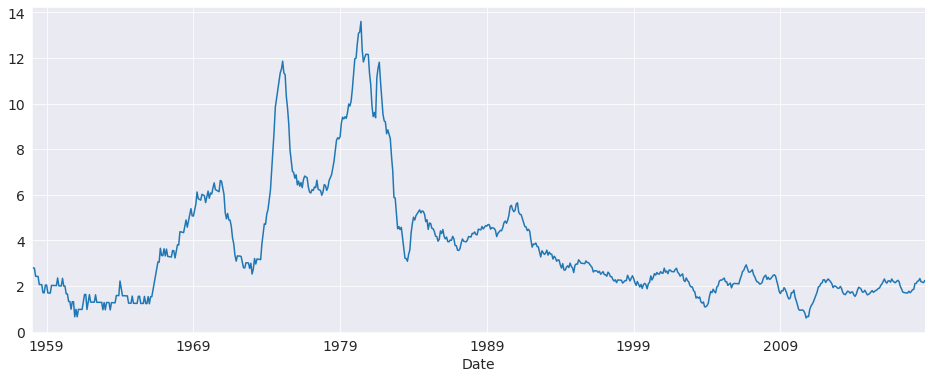

In [10]:
import arch.data.core_cpi
core_cpi = arch.data.core_cpi.load()
ann_inflation = 100 * core_cpi.CPILFESL.pct_change(12).dropna()
fig = ann_inflation.plot()

All mean models are initialized with constant variance and normal errors.  For `ARX` models, the `lags` argument specifies the lags to include in the model.

In [11]:
from arch.univariate import ARX

ar = ARX(ann_inflation, lags=[1, 3, 12])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:               CPILFESL   R-squared:                       0.991
Mean Model:                        AR   Adj. R-squared:                  0.991
Vol Model:          Constant Variance   Log-Likelihood:                11.2764
Distribution:                  Normal   AIC:                          -12.5529
Method:            Maximum Likelihood   BIC:                           10.3364
                                        No. Observations:                  719
Date:                Mon, Mar 02 2020   Df Residuals:                      714
Time:                        11:53:29   Df Model:                            5
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const            0.0402  2.030e-02      1.981  4.

### Volatility Processes

Volatility processes can be added a a mean model using the `volatility` property.  This example adds an ARCH(5) process to model volatility. The arguments `iter` and `disp` are used in `fit()` to suppress estimation output.

In [12]:
from arch.univariate import ARCH, GARCH

ar.volatility = ARCH(p=5)
res = ar.fit(update_freq=0, disp='off')
print(res.summary())

                           AR - ARCH Model Results                            
Dep. Variable:               CPILFESL   R-squared:                       0.991
Mean Model:                        AR   Adj. R-squared:                  0.991
Vol Model:                       ARCH   Log-Likelihood:                136.522
Distribution:                  Normal   AIC:                          -253.044
Method:            Maximum Likelihood   BIC:                          -207.265
                                        No. Observations:                  719
Date:                Mon, Mar 02 2020   Df Residuals:                      709
Time:                        11:53:29   Df Model:                           10
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const            0.0285  1.883e-02      1.513    

Plotting the standardized residuals and the conditional volatility shows some large (in magnitude) errors, even when standardized.

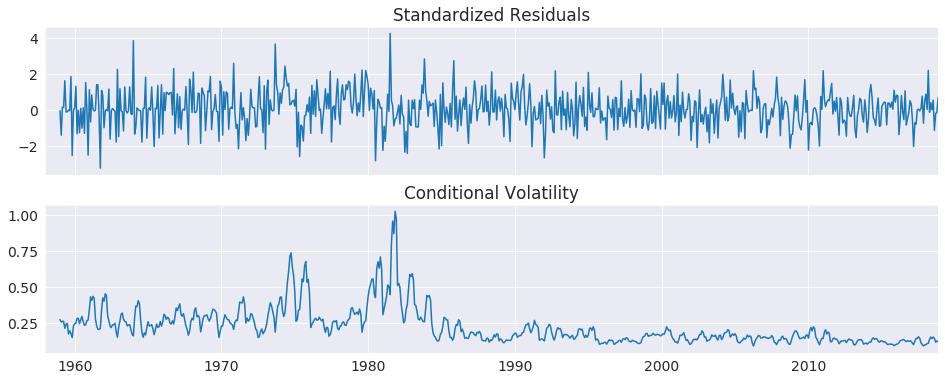

In [13]:
fig = res.plot()

### Distributions

Finally the distribution can be changed from the default normal to a standardized Student's T using the `distribution` property of a mean model.

The Student's t distribution improves the model, and the degree of freedom is estimated to be near 8.

In [14]:
from arch.univariate import StudentsT

ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp='off')
print(res.summary())

                              AR - ARCH Model Results                               
Dep. Variable:                     CPILFESL   R-squared:                       0.991
Mean Model:                              AR   Adj. R-squared:                  0.991
Vol Model:                             ARCH   Log-Likelihood:                142.863
Distribution:      Standardized Student's t   AIC:                          -263.727
Method:                  Maximum Likelihood   BIC:                          -213.370
                                              No. Observations:                  719
Date:                      Mon, Mar 02 2020   Df Residuals:                      708
Time:                              11:53:30   Df Model:                           11
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------

## WTI Crude

The next example uses West Texas Intermediate Crude data from FRED.  Three models are fit using alternative distributional assumptions.  The results are printed, where we can see that the normal has a much lower log-likelihood than either the Standard Student's T or the Standardized Skew Student's T -- however, these two are fairly close.  The closeness of the T and the Skew T indicate that returns are not heavily skewed.

In [21]:
from collections import OrderedDict

import arch.data.wti

crude = arch.data.wti.load()
crude_ret = 100 * crude.DCOILWTICO.dropna().pct_change().dropna()
res_normal = arch_model(crude_ret).fit(disp='off')
res_t = arch_model(crude_ret, dist='t').fit(disp='off')
res_skewt = arch_model(crude_ret, dist='skewt').fit(disp='off')
lls = pd.Series(
    OrderedDict((('normal', res_normal.loglikelihood),
                 ('t', res_t.loglikelihood), ('skewt',
                                              res_skewt.loglikelihood))))
print(lls)
params = pd.DataFrame(
    OrderedDict((('normal', res_normal.params), ('t', res_t.params),
                 ('skewt', res_skewt.params))))
params

normal   -18165.858870
t        -17919.643916
skewt    -17916.669052
dtype: float64


,normal,t,skewt
alpha[1],0.085627,0.064980,0.064889
beta[1],0.909098,0.927950,0.928215
lambda,NaN,NaN,-0.036986
mu,0.046682,0.056438,0.040928
nu,NaN,6.178652,6.186550
omega,0.055806,0.048516,0.047683


The standardized residuals can be computed by dividing the residuals by the conditional volatility.  These are plotted along with the (unstandardized, but scaled) residuals. The non-standardized residuals are more peaked in the center indicating that the distribution is somewhat more heavy tailed than that of the standardized residuals.

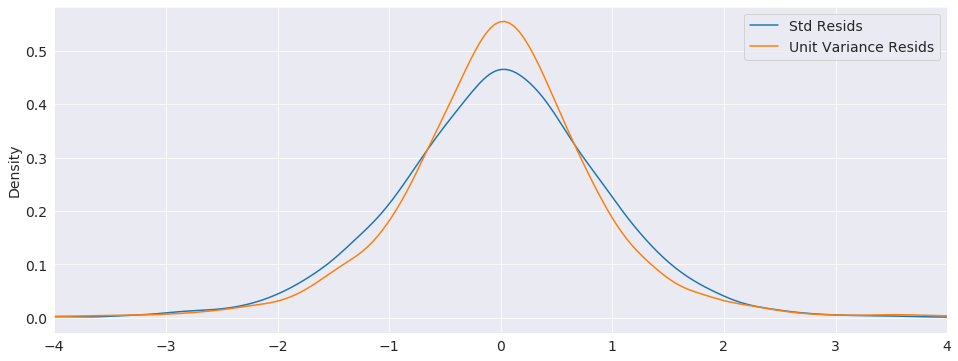

In [16]:
std_resid = res_normal.resid / res_normal.conditional_volatility
unit_var_resid = res_normal.resid / res_normal.resid.std()
df = pd.concat([std_resid, unit_var_resid], 1)
df.columns = ['Std Resids', 'Unit Variance Resids']
subplot = df.plot(kind='kde', xlim=(-4, 4))

## Simulation

All mean models expose a method to simulate returns from assuming the
model is correctly specified.  There are two required parameters, `params`
which are the model parameters, and `nobs`, the number of observations
to produce.

Below we simulate from a GJR-GARCH(1,1) with Skew-t errors using parameters
estimated on the WTI series.  The simulation returns a `DataFrame` with 3 columns:

* `data`: The simulated data, which includes any mean dynamics.
* `volatility`: The conditional volatility series
* `errors`: The simulated errors generated to produce the model. The errors are
  the difference between the data and its conditional mean, and can be transformed
  into the standardized errors by dividing by the volatility.

In [17]:
res = arch_model(crude_ret, p=1, o=1, q=1, dist='skewt').fit(disp='off')
pd.DataFrame(res.params)

,params
mu,0.029365
omega,0.044375
alpha[1],0.044344
gamma[1],0.036104
beta[1],0.931280
nu,6.211329
lambda,-0.041615


In [18]:
sim_mod = arch_model(None, p=1, o=1, q=1, dist="skewt")

sim_data = sim_mod.simulate(res.params, 1000)
sim_data.head()

,data,volatility,errors
0,-2.309897,2.058408,-2.339262
1,-0.114392,2.104869,-0.143758
2,-1.812156,2.042559,-1.841521
3,-1.348278,2.050008,-1.377643
4,-1.559034,2.027508,-1.588399


Simulations can be reproduced using a NumPy `RandomState`. This requires 
constructing a model from components where the `RandomState` instance is
passed into to the distribution when the model is created.

The cell below contains code that builds a model with a constant mean,
GJR-GARCH volatility and Skew $t$ errors initialized with a user-provided
`RandomState`. Saving the initial state allows it to be restored later so
that the simulation can be run with the same random values.   

In [19]:
from arch.univariate import ConstantMean, GARCH, SkewStudent
import numpy as np

rs = np.random.RandomState([892380934, 189201902, 129129894, 9890437])
# Save the initial state to reset later
state = rs.get_state()

dist = SkewStudent(random_state=rs)
vol = GARCH(p=1, o=1, q=1)
repro_mod = ConstantMean(None, volatility=vol, distribution=dist)

repro_mod.simulate(res.params, 1000).head()

,data,volatility,errors
0,1.616826,4.787664,1.587461
1,4.106756,4.637096,4.077391
2,4.530173,4.561424,4.500807
3,2.284819,4.507707,2.255454
4,3.378498,4.380984,3.349133


Resetting the state using `set_state` shows that calling `simulate`
using the same underlying state in the `RandomState` produces the
same objects. 

In [20]:
# Reset the state to the initial state
rs.set_state(state)
repro_mod.simulate(res.params, 1000).head()

,data,volatility,errors
0,1.616826,4.787664,1.587461
1,4.106756,4.637096,4.077391
2,4.530173,4.561424,4.500807
3,2.284819,4.507707,2.255454
4,3.378498,4.380984,3.349133
